In [1]:
%pip install ipython-sparql-pandas
# run `sparql?` in a cell for documentation
%load_ext ipython_sparql_pandas

Note: you may need to restart the kernel to use updated packages.


# 1. Pandas Plotting
First, make sure that `vuDataset.ttl` is loaded in GraphDb as the `repo-vu` repository.

In [2]:
%%sparql http://localhost:7200/repositories/repo-vu -s courseload
PREFIX vu: <http://example.org/vu/>

SELECT ?teacher (COUNT(*) as ?courses) {
    ?teacher vu:teaches ?o .
} GROUP BY ?teacher

teacher  courses
0  http://example.org/vu/stefan        5
1   http://example.org/vu/frank        3
2     http://example.org/vu/joe        1

<AxesSubplot:ylabel='courses'>

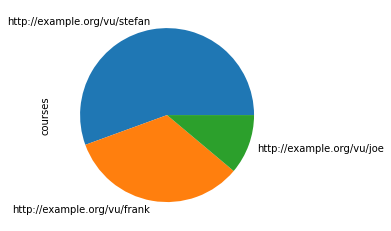

In [3]:
# Pandas visualization: https://pandas.pydata.org/docs/user_guide/visualization.html
courseload.set_index('teacher', inplace=True)
courseload['courses'].plot.pie()

In [4]:
### Assignment 5-1a: Make a horizontal bar chart from the `courseload` dataframe

In [5]:
### Assignment 5-1b: Write a new SPARQL query for DBpedia 
###    and create an interesting chart from it

# 2. Pandas styling

In [6]:
%%sparql http://dbpedia.org/sparql/ -q -s dbpedia_countries
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dcb: <http://dbpedia.org/resource/Category:>
PREFIX dbo: <http://dbpedia.org/ontology/>

SELECT DISTINCT ?name ?area_100k_km2 ?giniCoefficient WHERE {
    ?country 
        dct:subject dcb:Current_member_states_of_the_United_Nations ;
        dbo:area ?area ; # area is stated in m^2
        dbo:giniCoefficient ?giniCoefficient ;
        rdfs:label ?name. 
    
    BIND (ROUND(?area/100000000000) AS ?area_100k_km2)
    FILTER(LANG(?name) = 'en')
}
ORDER BY DESC(?area_100k_km2)
LIMIT 50

In [7]:
# Styling: https://pandas.pydata.org/docs/user_guide/style.html
# Using CSS Hue-Saturation-Level colors: https://www.w3schools.com/colors/colors_hsl.asp

def gini_color(gini):
    return f'background: hsl({100 - gini}, 100%, 50%)' 

dbpedia_countries.style \
    .applymap(gini_color, subset=(slice(None), "giniCoefficient"))

In [8]:
### Assignment: 
### Add a column with the percentage of the area of the country that is water.
### The background color of this column depend on its value:
###    it should greener if more the country is land,
###    and bluer if more of the country is water.

# 3. Folium Map

In [9]:
%%sparql http://query.wikidata.org/sparql -q -s capitals
SELECT ?capitalLabel ?coords WHERE {
    ?country
        wdt:P463 wd:Q458 ; # member of: European Union
        wdt:P36 ?capital . # capital: ?capital
        
    ?capital 
        wdt:P625 ?coords . # coordinate location: ?coords
    
    # Using Wikidata-only label service
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}

In [10]:
%pip install folium

Note: you may need to restart the kernel to use updated packages.


In [11]:
import folium
# Extract latitude and longitude from coordinates in Well-Known Text (WKT) format
capitals_coords = capitals.join(capitals.coords.str.extract('Point\((?P<lon>\S+) (?P<lat>\S+)\)').astype(float))

middle = [capitals_coords['lat'].mean(), capitals_coords['lon'].mean()]
m = folium.Map(location=middle, zoom_start=4)
for _, row in capitals_coords.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius= 20,
        popup= row['capitalLabel'],
        color="#3186cc",
        fill=True,
        fill_color="#3186cc",
    ).add_to(m)

m

In [12]:
### Assignment:
###   Make the markers bigger depending on the population of the capital
###   (but keep it readable!)
###   Tip: use the auto-complete functionality of http://query.wikidata.org

## Extra points: Why does Wikidata return that the UK is a member of the EU?